In [1]:
!pip install -q torchsummary
!pip install -q mat73

In [30]:
import os
import re
import zipfile
from IPython.display import clear_output
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from skimage.io import imread
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
from itertools import permutations

import torch
import cv2
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
from skimage.transform import resize
from torchvision.transforms import v2 as T
from torchvision.utils import make_grid
from torchsummary import summary
from torchvision.utils import save_image

from matplotlib import pyplot as plt
from torchvision.io import read_image, ImageReadMode

from torchvision.models import resnet50, ResNet50_Weights, inception_v3, densenet121, DenseNet121_Weights, resnet18, ResNet18_Weights
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from torch.utils.data import random_split
import mat73
import scipy

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)
plt.ion()


In [3]:
GENERATOR = torch.Generator().manual_seed(2001)
BATCH_SIZE = 64
IMG_SIZE = 128
modelDir = 'result/'

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Загрузка датасета SVHN (полная версия, от которой оставим номера от 1 до 99)

In [5]:
# !wget http://ufldl.stanford.edu/housenumbers/train.tar.gz

In [6]:
# !tar -xf train.tar.gz

In [7]:
# !unzip -q frames_2.zip

In [8]:
mat_contents = mat73.loadmat('train/digitStruct.mat')

In [9]:
def marker(lbl):
  mark = ('').join(list(map(lambda x: str(int(x)), lbl)))
  return int(mark)

In [10]:
labels = list(map(lambda x: x['label'], mat_contents['digitStruct']['bbox']))

In [11]:
label_list = []
for l in labels:
  try:
    len(l)
    pass
  except:
    l_1 = []
    l_1.append(l)
    l = l_1
  label_list.append(l)

In [12]:
annotations = pd.DataFrame(data={'images': mat_contents['digitStruct']['name'],
                                 'labels': pd.Series(label_list)})

In [13]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33402 entries, 0 to 33401
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  33402 non-null  object
 1   labels  33402 non-null  object
dtypes: object(2)
memory usage: 522.0+ KB


In [14]:
annotations.head()

,images,labels
0,1.png,"[1.0, 9.0]"
1,2.png,"[2.0, 3.0]"
2,3.png,"[2.0, 5.0]"
3,4.png,"[9.0, 3.0]"
4,5.png,"[3.0, 1.0]"


In [15]:
annotations['labels_1'] = annotations['labels'].apply(marker)

In [16]:
annotations = annotations.drop(['labels'], axis=1)

In [17]:
annotations.head()

,images,labels_1
0,1.png,19
1,2.png,23
2,3.png,25
3,4.png,93
4,5.png,31


In [18]:
annotations = annotations.loc[annotations['labels_1'] < 100]

In [19]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21241 entries, 0 to 33400
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   images    21241 non-null  object
 1   labels_1  21241 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 497.8+ KB


<Axes: >

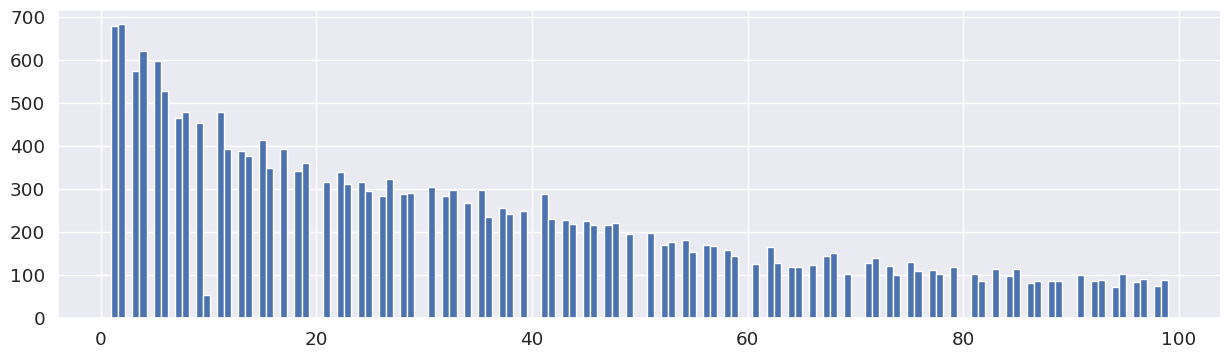

In [20]:
annotations['labels_1'].hist(bins=150)

In [21]:
annotations.to_csv('describe.csv')

In [22]:
numbers = annotations['labels_1'].nunique()
numbers

91

In [23]:
annotations['labels_1'].describe()

count    21241.000000
mean        33.208512
std         26.520412
min          1.000000
25%         11.000000
50%         27.000000
75%         51.000000
max         99.000000
Name: labels_1, dtype: float64

In [24]:
pl_nbs = list(set(list(map(lambda x: int(x.split('_')[-1].split('.')[0]), os.listdir('frames_2')))))

## Датасет и даталоадер

In [25]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((IMG_SIZE, IMG_SIZE)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomInvert()
    ])

In [26]:
class SVHN(torch.utils.data.Dataset):
    def __init__(self, root, anno, transform):
        self.root = root
        self.anno = anno
        self.label = list(self.anno['labels_1'])
        self.transforms = transform
        self.imgs = list(self.anno['images'])

    def __getitem__(self, idx):
        # load images and labels
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path)
        target = self.label[idx]

        return self.transforms(img), torch.tensor(target)

    def __len__(self):
        return len(self.imgs)

### И еще один датасет с игроками

In [27]:
class Players(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transforms = transform
        self.imgs = os.listdir(self.root)
        self.label = list(map(lambda x: int(x.split('_')[-1].split('.')[0]), self.imgs))

    def __getitem__(self, idx):
        # load images and labels
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path)
        target = self.label[idx]

        return self.transforms(img), torch.tensor(target)

    def __len__(self):
        return len(self.imgs)

targets: 1 to 99 and zero...

In [28]:
twodigits = SVHN('train/', annotations, transformer)
players = Players('frames_2/', transformer)

In [29]:
pl, pl_test = torch.utils.data.random_split(players, [.75, .25], generator=GENERATOR)
data = torch.utils.data.ConcatDataset([twodigits, pl])

In [31]:
train, valid, test = torch.utils.data.random_split(data, [.6, .2, .2], generator=GENERATOR)
print(f"train - {len(train)} \n valid - {len(valid)} \n test - {len(test)}")

train - 14591 
 valid - 4864 
 test - 4863


In [32]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(valid, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True)

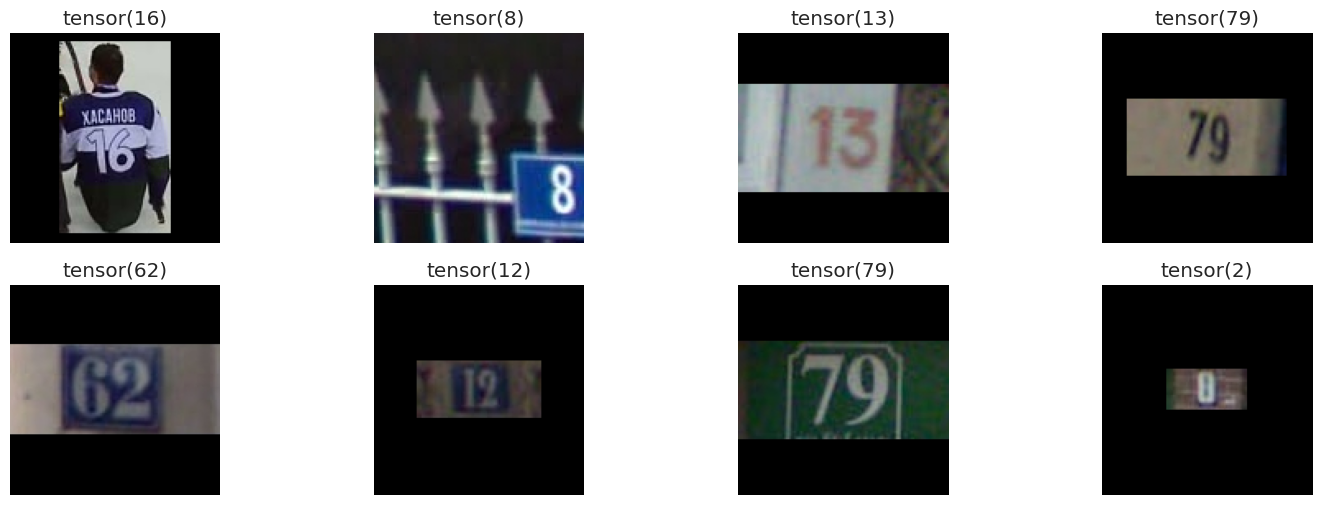

In [33]:
look = next(iter(train_loader))
plt.figure(figsize=(18, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(look[0][i].permute(1,2,0))
    plt.title(look[1][i])
plt.show()

## Загрузка модели

In [34]:
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)

# Set requires_grad = False for all parameters
# for param in resnet.parameters():
#     param.requires_grad = False

# # Re-enable requires_grad for the last 3 layers
# layers = list(resnet.children())
# for layer in layers[-10:]:
#     for param in layer.parameters():
#         param.requires_grad = True
in_features = 2048
out_features = 100
resnet.fc = nn.Linear(in_features, out_features)
resnet = resnet.to(device)
# summary(resnet, (3,IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

In [35]:
weights_1 = ResNet18_Weights.DEFAULT
resnet_1 = resnet18(weights=weights_1)

# Set requires_grad = False for all parameters
# for param in resnet.parameters():
#     param.requires_grad = False

# # Re-enable requires_grad for the last 3 layers
# layers = list(resnet.children())
# for layer in layers[-10:]:
#     for param in layer.parameters():
#         param.requires_grad = True
in_features_1 = 512
out_features = 100
resnet_1.fc = nn.Linear(in_features_1, out_features)
resnet_1 = resnet_1.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/eugene/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.7MB/s]


## Функции для обучения

In [36]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler_down, scheduler_up):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler_down.step()
    scheduler_up.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    rate = optimizer.param_groups[0]["lr"]
    print(f'learning rate -- {rate:.2}')
    return train_loss, train_acc, rate

In [37]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [38]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.eval()
            outputs = model(inputs)
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += inputs.size(0)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc

In [39]:
def trainer(train, val, model, epochs, rate, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=rate)
        sch_down = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
        sch_up = lr_scheduler.StepLR(opt, step_size=10, gamma=200)
#         sch = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=0.0003, max_lr=0.1,step_size_up=5,mode="triangular2", cycle_momentum=False)

        val_acc_p = 0
        for epoch in range(epochs):
            train_loss, train_acc, rate = fit_epoch(model, train, criterion, opt, sch_down, sch_up)
#             print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val, criterion)
            if val_acc > val_acc_p:
                torch.save(model.state_dict(), 'result/resnet_new.pth')
                print(f'save best model for {epoch} epoch')
                val_acc_p = val_acc
            history.append((train_loss, train_acc, val_loss, val_acc, rate))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [40]:
def vizualize(h):
    loss, acc, val_loss, val_acc, rate = zip(*h)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()
    plt.plot(np.log(rate), label="learning_rate", color='green')
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("learning rate (log scale)")
    plt.show()

In [41]:
ce = nn.CrossEntropyLoss()
lr = 3e-4

In [41]:
history = trainer(train_loader, val_loader, model=resnet, epochs=20, rate=lr, criterion=ce)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

learning rate -- 0.0003


epoch:   5%|▌         | 1/20 [00:50<15:50, 50.03s/it]

save best model for 0 epoch

Epoch 001 train_loss: 3.1807     val_loss 2.0909 train_acc 0.2480 val_acc 0.4500
learning rate -- 0.0003


epoch:  10%|█         | 2/20 [01:39<14:57, 49.87s/it]

save best model for 1 epoch

Epoch 002 train_loss: 1.3388     val_loss 1.2827 train_acc 0.6425 val_acc 0.6739
learning rate -- 0.0003


epoch:  15%|█▌        | 3/20 [02:30<14:15, 50.30s/it]

save best model for 2 epoch

Epoch 003 train_loss: 0.7618     val_loss 1.1232 train_acc 0.7912 val_acc 0.7109
learning rate -- 0.0003


epoch:  20%|██        | 4/20 [03:21<13:28, 50.50s/it]

save best model for 3 epoch

Epoch 004 train_loss: 0.4953     val_loss 1.1027 train_acc 0.8620 val_acc 0.7278
learning rate -- 3e-05


epoch:  25%|██▌       | 5/20 [04:12<12:39, 50.63s/it]

save best model for 4 epoch

Epoch 005 train_loss: 0.3177     val_loss 1.2159 train_acc 0.9104 val_acc 0.7381
learning rate -- 3e-05


epoch:  30%|███       | 6/20 [05:03<11:50, 50.73s/it]

save best model for 5 epoch

Epoch 006 train_loss: 0.1263     val_loss 1.0441 train_acc 0.9659 val_acc 0.7730
learning rate -- 3e-05


epoch:  35%|███▌      | 7/20 [05:54<11:00, 50.79s/it]

save best model for 6 epoch

Epoch 007 train_loss: 0.0571     val_loss 1.0768 train_acc 0.9874 val_acc 0.7757
learning rate -- 3e-05


epoch:  40%|████      | 8/20 [06:44<10:08, 50.72s/it]


Epoch 008 train_loss: 0.0354     val_loss 1.1353 train_acc 0.9936 val_acc 0.7718
learning rate -- 3e-05


epoch:  45%|████▌     | 9/20 [07:35<09:17, 50.69s/it]


Epoch 009 train_loss: 0.0218     val_loss 1.1733 train_acc 0.9968 val_acc 0.7736
learning rate -- 0.0006


epoch:  50%|█████     | 10/20 [08:25<08:26, 50.67s/it]


Epoch 010 train_loss: 0.0170     val_loss 1.1978 train_acc 0.9981 val_acc 0.7755
learning rate -- 0.0006


epoch:  55%|█████▌    | 11/20 [09:16<07:35, 50.63s/it]


Epoch 011 train_loss: 0.8877     val_loss 1.4590 train_acc 0.7601 val_acc 0.6565
learning rate -- 0.0006


epoch:  60%|██████    | 12/20 [10:07<06:44, 50.61s/it]


Epoch 012 train_loss: 0.5741     val_loss 1.2856 train_acc 0.8400 val_acc 0.7044
learning rate -- 0.0006


epoch:  65%|██████▌   | 13/20 [10:57<05:54, 50.58s/it]


Epoch 013 train_loss: 0.3498     val_loss 1.2227 train_acc 0.8988 val_acc 0.7362
learning rate -- 0.0006


epoch:  70%|███████   | 14/20 [11:48<05:03, 50.58s/it]


Epoch 014 train_loss: 0.2368     val_loss 1.2078 train_acc 0.9298 val_acc 0.7366
learning rate -- 6e-05


epoch:  75%|███████▌  | 15/20 [12:38<04:12, 50.57s/it]


Epoch 015 train_loss: 0.1626     val_loss 1.2596 train_acc 0.9524 val_acc 0.7455
learning rate -- 6e-05


epoch:  80%|████████  | 16/20 [13:29<03:22, 50.72s/it]

save best model for 15 epoch

Epoch 016 train_loss: 0.0567     val_loss 1.0939 train_acc 0.9851 val_acc 0.7843
learning rate -- 6e-05


epoch:  85%|████████▌ | 17/20 [14:20<02:32, 50.74s/it]

save best model for 16 epoch

Epoch 017 train_loss: 0.0135     val_loss 1.1312 train_acc 0.9979 val_acc 0.7880
learning rate -- 6e-05


epoch:  90%|█████████ | 18/20 [15:11<01:41, 50.80s/it]

save best model for 17 epoch

Epoch 018 train_loss: 0.0076     val_loss 1.1921 train_acc 0.9992 val_acc 0.7882
learning rate -- 6e-05


epoch:  95%|█████████▌| 19/20 [16:02<00:50, 50.81s/it]

save best model for 18 epoch

Epoch 019 train_loss: 0.0049     val_loss 1.2293 train_acc 0.9994 val_acc 0.7926
learning rate -- 0.0012


epoch: 100%|██████████| 20/20 [16:52<00:00, 50.65s/it]


Epoch 020 train_loss: 0.0036     val_loss 1.2626 train_acc 0.9997 val_acc 0.7924


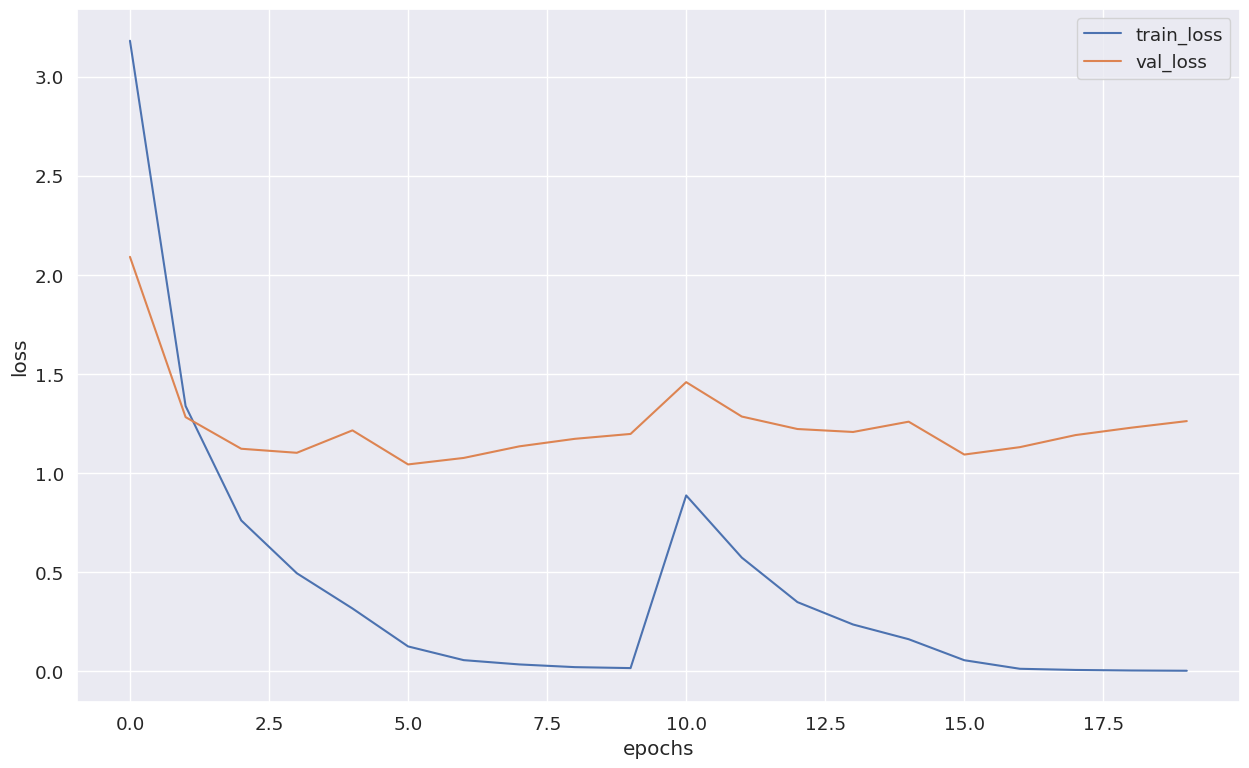

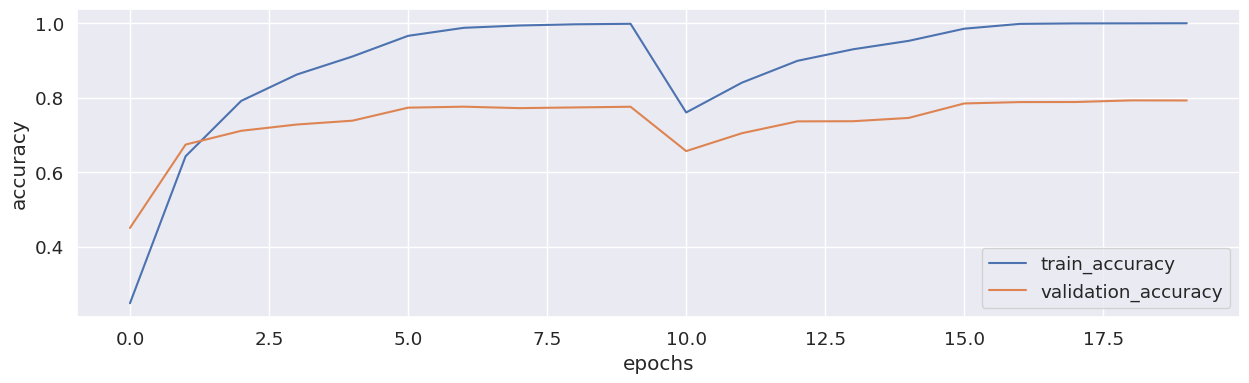

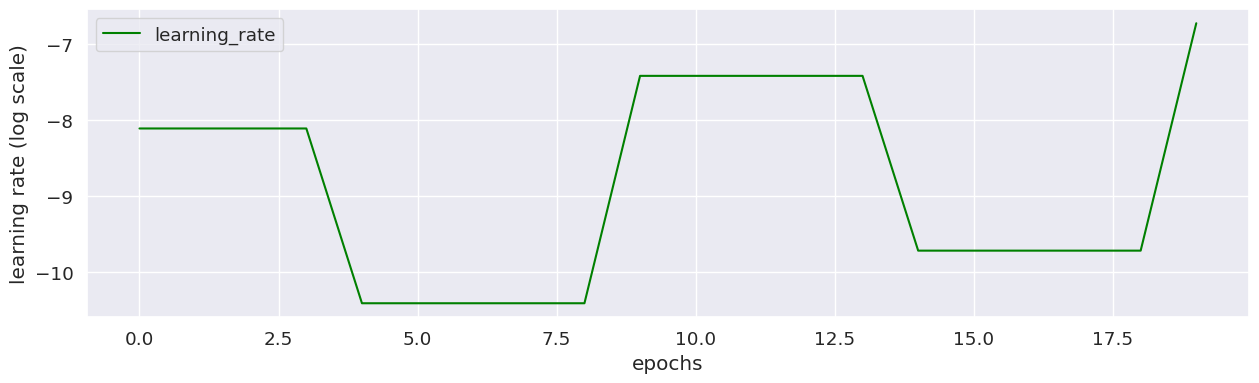

In [42]:
vizualize(history)

In [42]:
history_1 = trainer(train_loader, val_loader, model=resnet_1, epochs=20, rate=lr, criterion=ce)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

learning rate -- 0.0003


epoch:   5%|▌         | 1/20 [00:51<16:21, 51.67s/it]

save best model for 0 epoch

Epoch 001 train_loss: 3.1203     val_loss 2.1434 train_acc 0.2593 val_acc 0.4293
learning rate -- 0.0003


epoch:  10%|█         | 2/20 [01:09<09:33, 31.86s/it]

save best model for 1 epoch

Epoch 002 train_loss: 1.5274     val_loss 1.5093 train_acc 0.5970 val_acc 0.6059
learning rate -- 0.0003


epoch:  15%|█▌        | 3/20 [01:27<07:13, 25.52s/it]

save best model for 2 epoch

Epoch 003 train_loss: 0.9954     val_loss 1.4136 train_acc 0.7344 val_acc 0.6375
learning rate -- 0.0003


epoch:  20%|██        | 4/20 [01:45<06:00, 22.56s/it]

save best model for 3 epoch

Epoch 004 train_loss: 0.7028     val_loss 1.3617 train_acc 0.8069 val_acc 0.6649
learning rate -- 3e-05


epoch:  25%|██▌       | 5/20 [02:03<05:13, 20.89s/it]


Epoch 005 train_loss: 0.5131     val_loss 1.3822 train_acc 0.8546 val_acc 0.6622
learning rate -- 3e-05


epoch:  30%|███       | 6/20 [02:21<04:39, 19.96s/it]

save best model for 5 epoch

Epoch 006 train_loss: 0.2136     val_loss 1.0992 train_acc 0.9470 val_acc 0.7412
learning rate -- 3e-05


epoch:  35%|███▌      | 7/20 [02:39<04:12, 19.40s/it]

save best model for 6 epoch

Epoch 007 train_loss: 0.1272     val_loss 1.1360 train_acc 0.9723 val_acc 0.7420
learning rate -- 3e-05


epoch:  40%|████      | 8/20 [02:58<03:48, 19.01s/it]

save best model for 7 epoch

Epoch 008 train_loss: 0.0904     val_loss 1.1570 train_acc 0.9818 val_acc 0.7434
learning rate -- 3e-05


epoch:  45%|████▌     | 9/20 [03:16<03:26, 18.78s/it]

save best model for 8 epoch

Epoch 009 train_loss: 0.0654     val_loss 1.1813 train_acc 0.9891 val_acc 0.7477
learning rate -- 0.0006


epoch:  50%|█████     | 10/20 [03:34<03:05, 18.59s/it]


Epoch 010 train_loss: 0.0454     val_loss 1.2109 train_acc 0.9940 val_acc 0.7467
learning rate -- 0.0006


epoch:  55%|█████▌    | 11/20 [03:52<02:46, 18.45s/it]


Epoch 011 train_loss: 1.1703     val_loss 1.4774 train_acc 0.6888 val_acc 0.6402
learning rate -- 0.0006


epoch:  60%|██████    | 12/20 [04:10<02:27, 18.39s/it]


Epoch 012 train_loss: 0.7998     val_loss 1.5194 train_acc 0.7763 val_acc 0.6396
learning rate -- 0.0006


epoch:  65%|██████▌   | 13/20 [04:29<02:08, 18.36s/it]


Epoch 013 train_loss: 0.5699     val_loss 1.4336 train_acc 0.8366 val_acc 0.6641
learning rate -- 0.0006


epoch:  70%|███████   | 14/20 [04:47<01:50, 18.34s/it]


Epoch 014 train_loss: 0.3911     val_loss 1.3869 train_acc 0.8866 val_acc 0.6957
learning rate -- 6e-05


epoch:  75%|███████▌  | 15/20 [05:05<01:31, 18.31s/it]


Epoch 015 train_loss: 0.3028     val_loss 1.8734 train_acc 0.9110 val_acc 0.6283
learning rate -- 6e-05


epoch:  80%|████████  | 16/20 [05:24<01:13, 18.34s/it]

save best model for 15 epoch

Epoch 016 train_loss: 0.1108     val_loss 1.2328 train_acc 0.9694 val_acc 0.7502
learning rate -- 6e-05


epoch:  85%|████████▌ | 17/20 [05:42<00:55, 18.36s/it]

save best model for 16 epoch

Epoch 017 train_loss: 0.0405     val_loss 1.2805 train_acc 0.9924 val_acc 0.7514
learning rate -- 6e-05


epoch:  90%|█████████ | 18/20 [06:01<00:36, 18.39s/it]

save best model for 17 epoch

Epoch 018 train_loss: 0.0242     val_loss 1.3068 train_acc 0.9966 val_acc 0.7535
learning rate -- 6e-05


epoch:  95%|█████████▌| 19/20 [06:19<00:18, 18.40s/it]

save best model for 18 epoch

Epoch 019 train_loss: 0.0168     val_loss 1.3330 train_acc 0.9981 val_acc 0.7539
learning rate -- 0.0012


epoch: 100%|██████████| 20/20 [06:37<00:00, 19.90s/it]

save best model for 19 epoch

Epoch 020 train_loss: 0.0119     val_loss 1.3550 train_acc 0.9992 val_acc 0.7551


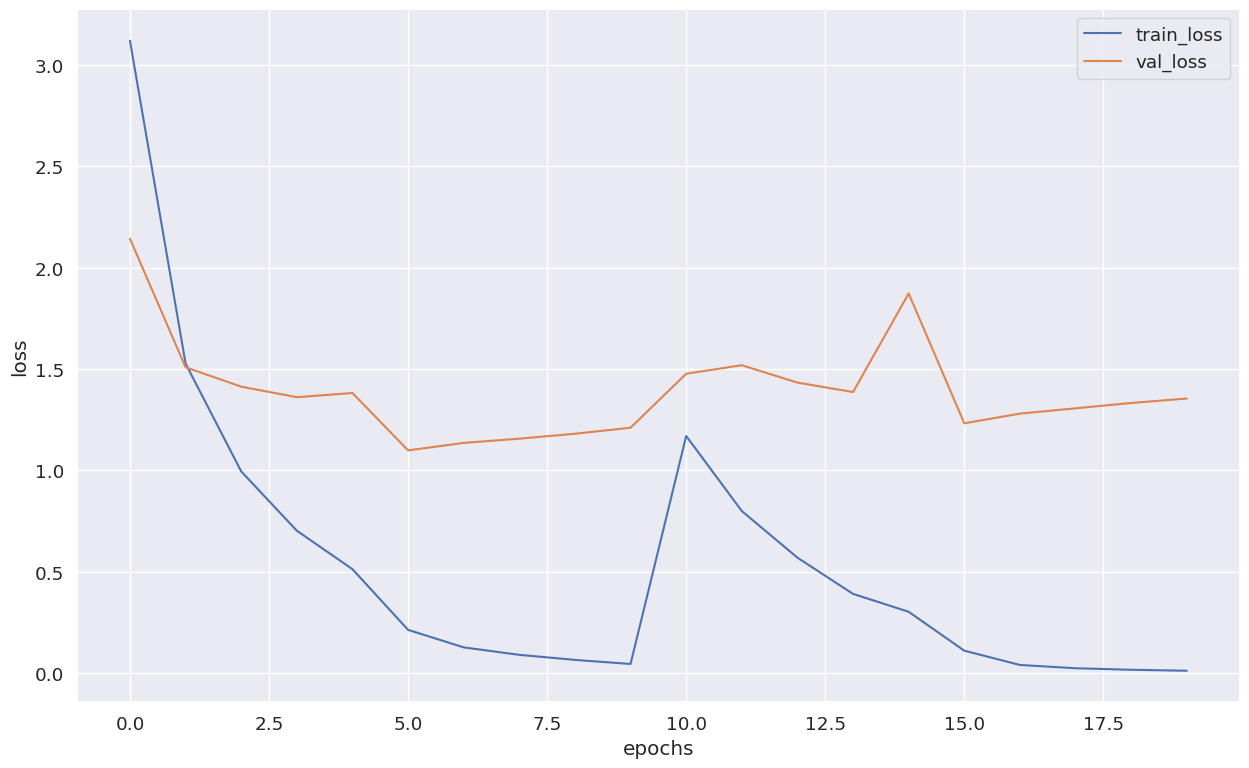

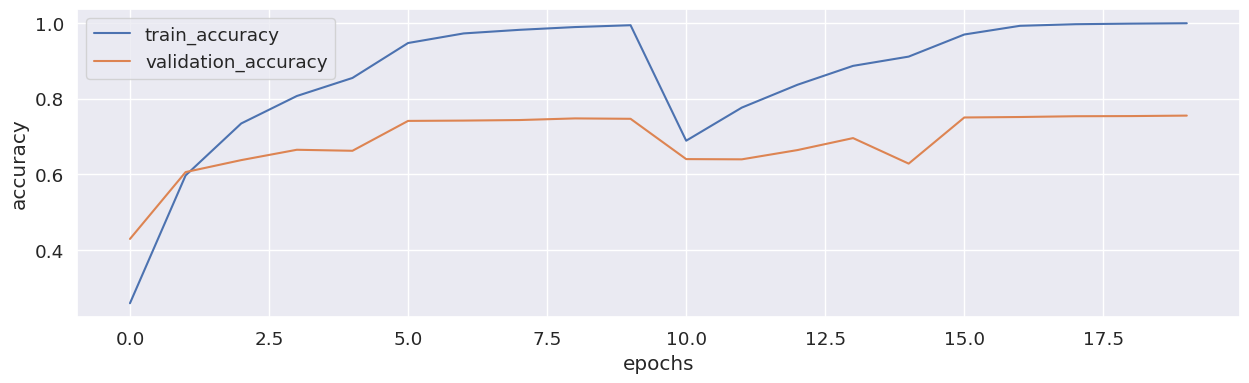

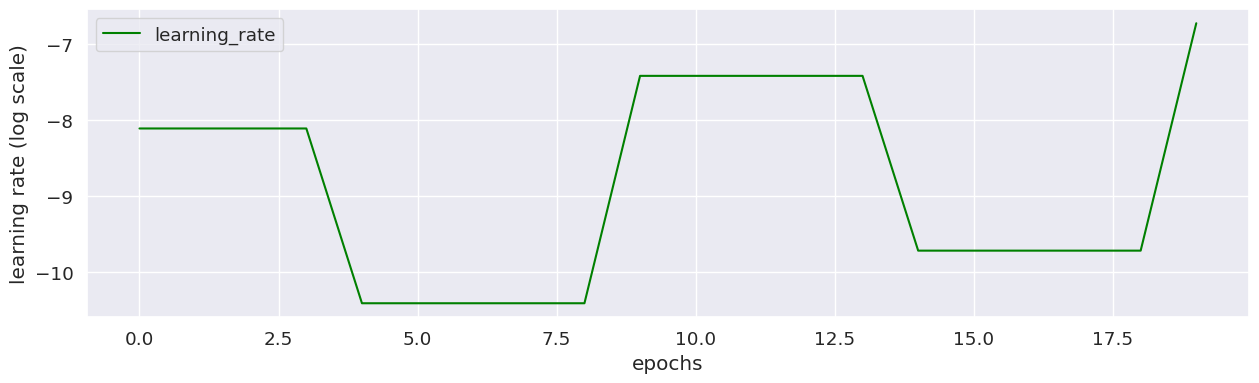

In [43]:
vizualize(history_1)

In [43]:
result = predict(resnet, test_loader)

In [44]:
print(f'Accuracy at test - {result[3]:.2}')

Accuracy at test - 0.8


In [44]:
result = predict(resnet_1, test_loader)

In [45]:
print(f'Accuracy at test - {result[3]:.2}')

Accuracy at test - 0.75


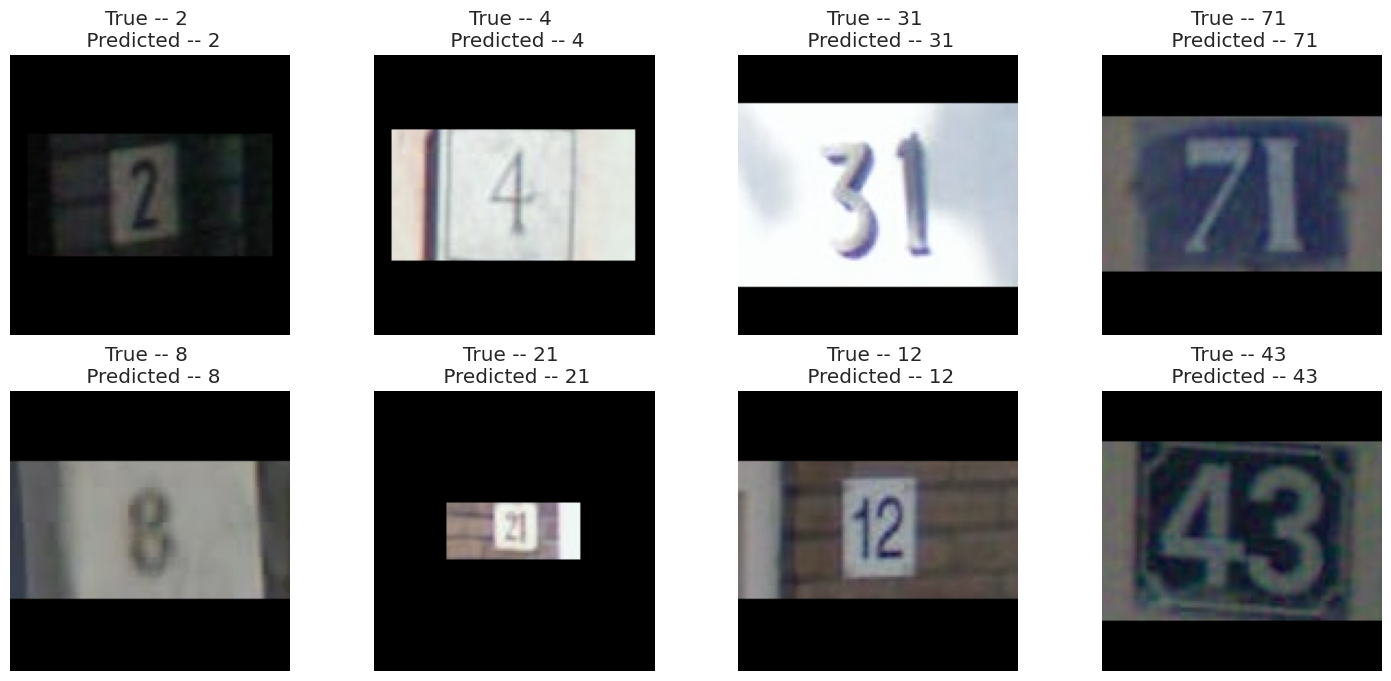

In [45]:
idx = np.random.randint(0, len(test), 8)
plt.figure(figsize=(18, 8))

for i in range(len(idx)):
  data = test[idx[i]]
  output = resnet(data[0].to(device).unsqueeze(0))
  pred = torch.argmax(output, 1).cpu()
  plt.subplot(2, 4, i+1)
  plt.axis("off")
  plt.imshow(data[0].permute(1,2,0))
  plt.title(f'True -- {data[1]} \n Predicted -- {int(pred)}')
plt.show()

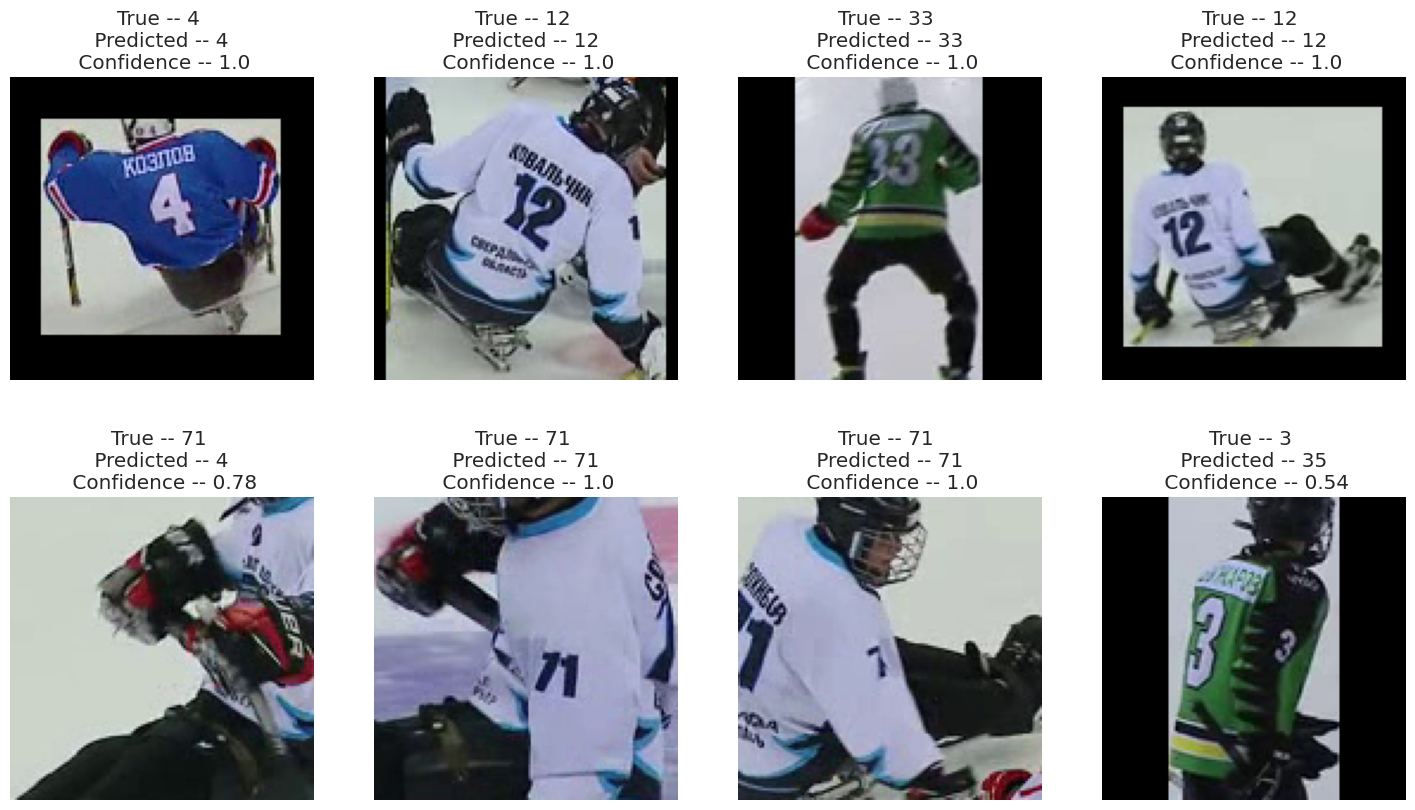

In [46]:
idx = np.random.randint(0, len(pl_test), 8)
plt.figure(figsize=(18, 10))

for i in range(len(idx)):
  data = pl_test[idx[i]]
  output = resnet(data[0].to(device).unsqueeze(0))
  pred = torch.argmax(output, 1).cpu()
  confidence = max(nn.functional.softmax(output)[0])
  plt.subplot(2, 4, i+1)
  plt.axis("off")
  plt.imshow(data[0].permute(1,2,0))
  plt.title(f'True -- {data[1]} \n Predicted -- {int(pred)} \n Confidence -- {confidence:.2}')
plt.show()

In [47]:
# model.load_state_dict(torch.load(params_path, map_location=torch.device(device)))

In [47]:
def correct(num: int, predictions: torch.tensor, numbers: list):
    """try to correct mistake in one number with hypothesis of similar numbers"""
    num = str(num)
    numbers = list(map(str, numbers))
    sim_numbs = [['1', '4', '7'], ['3', '5', '8'], ['8', '9', '0']]
    variants = []
    if num in numbers:
        return int(num)
    else:
        num_str = list(str(num))
        for i in range(len(sim_numbs)):
            for sym in num_str:
                if sym in sim_numbs[i]:
                    perms = list(permutations(sim_numbs[i], 2))
                    for j in range(len(perms)):
                        if sym in perms[j]:
                            for sym_p in perms[j]:
                                for k in range(len(num_str)):
                                    num_str[k] = sym_p
                                    v = ''.join(num_str)
                                    if v in numbers:
                                        variants.append(v)
    if len(variants) != 0:
        variants = list(map(int, list(set(variants))))
        pred_max = -1e6
        idx = 0
        for i in range(len(variants)):
            # print(f'{variants[i]} |---| {predictions[variants[i]]}')
            if predictions[variants[i]] >= pred_max:
                pred_max = predictions[variants[i]]
                idx = variants[i]
            i += 1
        return idx
    else:
        return 'unknown'

In [48]:
answ = []
for i in range(len(pl_test)):
    data = pl_test[i]
    answ.append(int(data[1]))
num_list = list(set(answ))
len(num_list)

36

In [49]:
answ = []
p_preds = []
preds = []
confs = []
corrs = []
acc = 0
cor_acc = 0
for i in range(len(pl_test)):
  data = pl_test[i]
  with torch.no_grad():
      output = resnet(data[0].to(device).unsqueeze(0))
  pred = torch.argmax(output, 1).cpu()
  cfs = nn.functional.softmax(output)[0]
  p_res = max(cfs).cpu().detach().numpy()
  c = correct(int(pred), output.cpu()[0], num_list)
  corrs.append(c)
  answ.append(int(data[1]))
  preds.append(int(pred))
  confs.append(p_res)
  acc += int(pred) == int(data[1])
  cor_acc += c == int(data[1])

In [50]:
result = pd.DataFrame({'true number': pd.Series(answ),
                       'predicted number': pd.Series(preds),
                       'confidence': pd.Series(confs), 
                       'corrected number': pd.Series(corrs)})

In [51]:
result

,true number,predicted number,confidence,corrected number
0,33,33,0.9957722,33
1,35,35,0.9998704,35
2,18,18,0.999915,18
3,12,12,0.9999914,12
4,97,97,0.9997149,97
...,...,...,...,...
1020,15,15,0.9999876,15
1021,16,16,0.9999906,16
1022,27,27,0.99795663,27
1023,99,71,0.92669517,71


In [52]:
result['s'] = result['predicted number'] - result['corrected number']
result.loc[result['s'] != 0]

,true number,predicted number,confidence,corrected number,s
206,10,39,0.5406793,35,4
338,55,39,0.3356805,55,-16


In [53]:
print(f'accuracy = {acc / len(pl_test)}')
print(f'corrected accuracy = {cor_acc / len(pl_test)}')

accuracy = 0.8790243902439024
corrected accuracy = 0.88


## А это датасет для однозначных чисел

In [ ]:
onedigit = datasets.SVHN(root='/content/', split='train', transform=transforms.ToTensor(), download=True)

100%|██████████| 182040794/182040794 [00:17<00:00, 10337852.18it/s]


In [ ]:
train, valid, test = torch.utils.data.random_split(onedigit, [.6, .2, .2], generator=GENERATOR)
print(f"train - {len(train)} \n valid - {len(valid)} \n test - {len(test)}")

train - 43955 
 valid - 14651 
 test - 14651


In [ ]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(valid, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True)

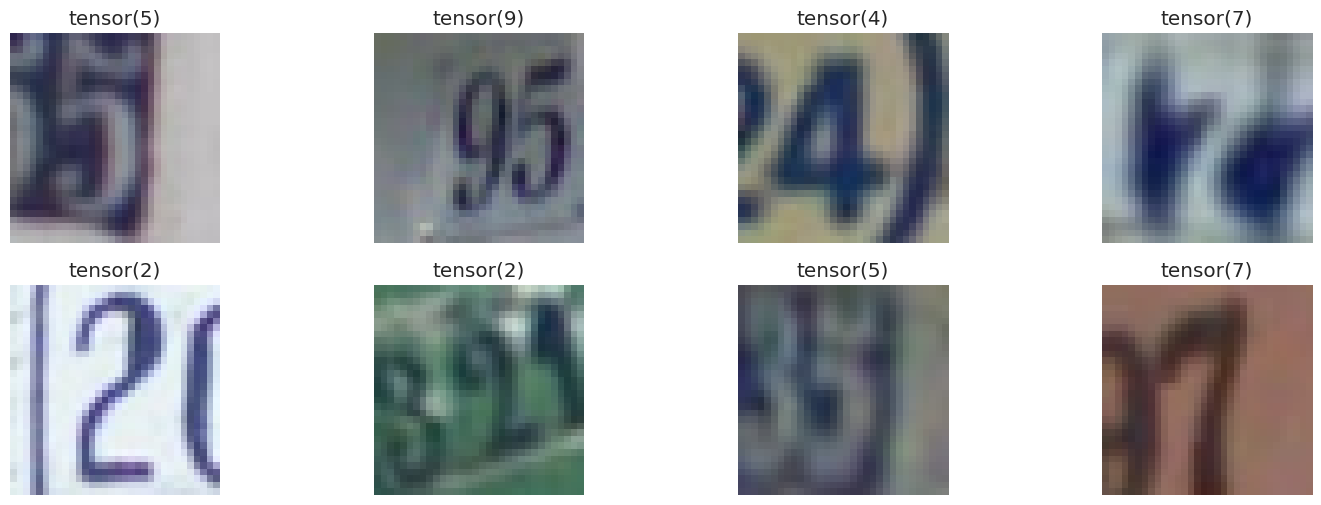

In [ ]:
look = next(iter(train_loader))
plt.figure(figsize=(18, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(look[0][i].permute(1,2,0))
    plt.title(look[1][i])
plt.show()